In [1]:
import pandas as pd
import numpy as np

names=['Datum(UTC)','Nicht Erneuerbar (MW)', 'Erneuerbar (MW)', 'DE-LU Day Ahead EUR/MWh']
DayAheadPrices=pd.read_csv("Daten entsoe/energy-charts_Stromproduktion_und_Börsenstrompreise_in_Deutschland_2024.csv",skiprows=2,names=names)

In [2]:
#preis_menge=DayAheadPrices
DayAheadPrices['datum']=pd.to_datetime(DayAheadPrices['Datum(UTC)'])
DayAheadPrices=DayAheadPrices.set_index('datum')
preis_menge=DayAheadPrices

In [3]:
names=['Datum','Jahr', 'Monat', 'Tag','PV IK8']
IKPV=pd.read_csv("Daten IK8/2024 PV Daily.csv",skiprows=1,names=names,sep=';',decimal=',',parse_dates=['Datum'],date_format='%d.%m.%Y').fillna(0)
IKPV=IKPV.drop(columns=['Jahr', 'Monat', 'Tag'])
IKPV=IKPV.set_index('Datum')

In [4]:
IKStrom=pd.read_csv("Daten IK8/2024 Hist Strom.csv",date_format='ISO8601',parse_dates=True,decimal='.')
IKStrom['last_changed dt']=pd.to_datetime(IKStrom['last_changed']).dt.floor('h')
IKStrom=IKStrom.set_index('last_changed dt')
ent_filter=['sensor.haushalt_positive_active_energy_total','sensor.haushalt_negative_active_energy_total','sensor.waermepumpe_positive_active_energy_total','sensor.waermepumpe_negative_active_energy_total']
IKStrom=IKStrom[IKStrom['entity_id'].isin(ent_filter)]
IKStrom['state']=pd.to_numeric(IKStrom['state'])
IKStrom=IKStrom.groupby('entity_id').resample('h')['state'].agg(['min']).ffill()
IKStrom=IKStrom.reset_index().pivot(index=['last_changed dt'],columns='entity_id',values='min')
IKStrom=IKStrom.ffill()

In [5]:
preis_menge[['Haus H','Haus S','WP H','WP S']]=IKStrom.diff().shift(-1).fillna(0)
preis_menge['DT']=preis_menge.index.date
#preis_menge['WP PV']=preis_menge['Haus H']-preis_menge['WP H']


In [6]:
cnt = 0
gap_cnt=0
gap=[]
cols=['Haus S','Haus H']
colsw=['WP S','WP H']
names=['Uhrzeit','kW']
#cols=['Haus S','Haus H']
#gap_save=[]
# Fülle PV auf Haus
for index,row in preis_menge.iterrows():
    sv=""
    #sm = row['Haus S']+row['Haus H']
    sm = row[cols[0]]+row[cols[1]]
    smw = row[cols[0]]+row[cols[1]]
    if sm == 0:
        #print(index)
        cnt +=1
        gap_cnt += 1
        gap=gap+[index]
    else:
        if len(gap)>0:
            gap=gap+[index]
            gap=gap+[min(gap)-pd.DateOffset(hours=1)]
            #print(index,gap_cnt,cnt)
            day_before_gap=min(gap).floor('d')-pd.DateOffset(days=1)
            
            gap_df=pd.DataFrame(gap,columns=['Datum'])
            gap_days=pd.DataFrame(gap_df['Datum'].dt.date.unique(),columns=['Datum']).set_index('Datum')
            gap_days['PV IK8']=IKPV['PV IK8']
            
            # Wieviele % und wie viel PW muss insgesamt auf den Tag verteilt werden
            # anderer Ansatz:
            #
            # Summe PV und Haushaltsstrom wird in Vergleich gesetzt und Verbrauch HH wird über die Tage verteilt. 
            for gd_index,gd_row in gap_days.iterrows():
                #print()
                r=gd_index
                miss_IK_PV=pd.read_csv("Daten IK8/Wechselrichter_Tag_{}-{:02d}-{:02d}.csv".format(r.year,r.month,r.day),names=names,sep=';',decimal=',',skiprows=1)
                miss_IK_PV=miss_IK_PV.groupby(miss_IK_PV.index//4-1)['kW'].agg(['sum'])*1000/4  
                miss_IK_PV=miss_IK_PV[miss_IK_PV.index>=0]
                for miss_PV_index, miss_PV_row in miss_IK_PV.iterrows():
                    new_date=pd.to_datetime('{} {:02d}'.format(gd_index,miss_PV_index),format='%Y-%m-%d %H',utc=True)
                    gap_df.loc[gap_df['Datum']==new_date,['Wert']]=miss_PV_row['sum']
                    gap_df=gap_df.fillna(0)
            gap_sum_haus_s=sum(preis_menge[preis_menge.index.isin(gap_df['Datum'])]['Haus S'])
            gap_count_s=len(gap_df.index)
            gap_avg_haus_s=gap_sum_haus_s/gap_count_s
            gap_genug_pv=len(gap_df[gap_df['Wert']>gap_avg_haus_s])
            gap_fill_haus_s=round(gap_sum_haus_s/(gap_count_s-gap_genug_pv))
            gap_df['fill HaS']=(gap_fill_haus_s-gap_df['Wert']).clip(lower=0)
            gap_df['fill HaH']=(gap_df['Wert']-gap_fill_haus_s).clip(lower=0)

            for gapdf_index, gapdf_row in gap_df.iterrows():
                gd_datum=gapdf_row['Datum']
                preis_menge.loc[preis_menge.index==gd_datum,'Haus H']=gapdf_row['fill HaH']
                preis_menge.loc[preis_menge.index==gd_datum,'Haus S']=gapdf_row['fill HaS']
            
            save_gap=gap
            save_row=row
            gap=[]
            gap_cnt=0
            #print(row)
            #print(gap_days)

# Fülle Haus auf WP
cnt = 0
gap_cnt=0
gap=[]
for index,row in preis_menge.iterrows():
    sv=""
    smw = row[colsw[0]]+row[colsw[1]]    
    if smw == 0:
        #print(index)
        cnt +=1
        gap_cnt += 1
        gap=gap+[index]
    else:
        if len(gap)>0:
            gap=gap+[index]
            gap=gap+[min(gap)-pd.DateOffset(hours=1)]
            #print(index,gap_cnt,cnt)
            day_before_gap=min(gap).floor('d')-pd.DateOffset(days=1)
            
            gap_df=pd.DataFrame(gap,columns=['Datum'])
            gap_days=pd.DataFrame(gap_df['Datum'].dt.date.unique(),columns=['Datum']).set_index('Datum')
            gap_days['PV IK8']=IKPV['PV IK8']

            gap_sum_hh_h=sum(preis_menge[preis_menge.index.isin(gap_df['Datum'])]['Haus H'])
            gap_sum_hh_s=sum(preis_menge[preis_menge.index.isin(gap_df['Datum'])]['Haus S'])
            gap_sum_wp_h=sum(preis_menge[preis_menge.index.isin(gap_df['Datum'])]['WP H'])
            gap_sum_wp_s=sum(preis_menge[preis_menge.index.isin(gap_df['Datum'])]['WP S'])

            gap_verbrauch_wp=gap_sum_hh_h-gap_sum_hh_s+gap_sum_wp_s-gap_sum_wp_h
            gap_count_s=len(gap_df.index)
            gap_avg_wp_v=gap_verbrauch_wp/gap_count_s

            # Überlegen ...
            for gapdf_index, gapdf_row in gap_df.iterrows():
                #print(gapdf_index)
                gd_datum=gapdf_row['Datum']

                wert_Haus_H=sum(preis_menge[preis_menge.index==gd_datum]['Haus H'])
                wert_Haus_S=sum(preis_menge[preis_menge.index==gd_datum]['Haus S'])

                fill_WP_H=max(0,wert_Haus_H-gap_avg_wp_v-wert_Haus_S)
                fill_WP_S=max(0,gap_avg_wp_v-wert_Haus_H+wert_Haus_S)
                #if wert_Haus_H< gap_avg_wp_v:
                #    fill_WP_H=0
                #else:
                #    fill_WP_H
                
                preis_menge.loc[preis_menge.index==gd_datum,'WP H']=fill_WP_H
                preis_menge.loc[preis_menge.index==gd_datum,'WP S']=fill_WP_S

            gap=[]
            gap_cnt=0

            
            
preis_menge['WP']=preis_menge['WP S']-preis_menge['Haus S']+preis_menge['Haus H']-preis_menge['WP H']
preis_menge['Haus']=preis_menge['Haus S']
preis_menge['PV']=preis_menge['WP H']

preis_menge['EUR WP']   = preis_menge['WP']* preis_menge['DE-LU Day Ahead EUR/MWh']  /1000000
preis_menge['EUR Haus'] = preis_menge['Haus']* preis_menge['DE-LU Day Ahead EUR/MWh']/1000000
preis_menge['EUR PV']   = preis_menge['PV']* preis_menge['DE-LU Day Ahead EUR/MWh']  /1000000
pm_cat=preis_menge['DE-LU Day Ahead EUR/MWh']
preis_menge['+-']=(np.where(pm_cat<0,'0: <0',np.where(pm_cat<70,'1: 0-7',np.where(pm_cat<260,'2: 7-26','3: 26-'))))
print(cnt)

421


In [7]:
wetter=pd.read_csv('Wetter/2024_Wetter_Station_020_Mengen_hh24.csv',sep=';',decimal=',')
wetter['Datum']=pd.to_datetime(wetter['Tag']+' '+wetter['Stunde'],format='%d.%m.%Y %H:%M',utc=True)
wetter=wetter.set_index('Datum')
preis_menge['AVG_TA200']=wetter['AVG_TA200']
preis_menge['SUM_GS200']=wetter['SUM_GS200']
preis_menge['SUM_NN050']=wetter['SUM_NN050']
		

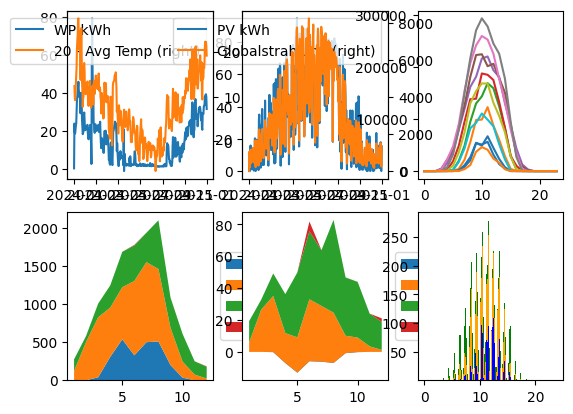

In [117]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
fig=plt.figure()
#, axs = plt.subplots(2,3)
ax1=fig.add_subplot(2,3,1)
ax3=fig.add_subplot(2,3,4)
ax2=fig.add_subplot(2,3,2)
ax4=fig.add_subplot(2,3,5)
ax5=fig.add_subplot(2,3,3)
ax6=fig.add_subplot(2,3,6)
#ax3=axs[0,1]
#ax2=axs[1,0]
#ax4=axs[1,1]
#ax5=axs[0,2]
#ax6=axs[1,2]
#aglevel=month
gpby=preis_menge.index.date

pm_day=preis_menge.groupby(gpby)['PV'].agg(['sum','max'])
pm_day['WP sum']=preis_menge.groupby(gpby)['WP'].agg(['sum'])/1000
pm_day['PV sum']=preis_menge.groupby(gpby)['PV'].agg(['sum'])/1000
pm_day['Haus sum']=preis_menge.groupby(gpby)['Haus'].agg(['sum'])/1000
pm_day['Temp avg']=20-preis_menge.groupby(gpby)['AVG_TA200'].agg(['mean'])
pm_day['Glob sum']=preis_menge.groupby(gpby)['SUM_GS200'].agg(['sum'])

pm_day['PV sum'].plot(ax=ax2,label="PV kWh", legend=True)
pm_day['WP sum'].plot(ax=ax1,label="WP kWh", legend=True)

#ax.scatter(pm_day.index,pm_day['Temp avg'])
pm_day['Temp avg'].plot(ax=ax1,secondary_y=True, label="20 - Avg Temp", legend=True)
pm_day['Glob sum'].plot(ax=ax2,secondary_y=True, label="Globalstrahlung", legend=True)


pv_kwh=[]
pv_wert=[]
labels = []
pm_pv=[]
for cur in sorted(preis_menge['+-'].unique()):
    d_dir=cur
    gpby=preis_menge[preis_menge['+-']==d_dir].index.month
    gpby_first=preis_menge.index.month
    if len(pm_pv)<2:
        pm_pv=preis_menge.groupby(gpby_first)['PV'].agg(['max'])
    pm_pv['PV '+d_dir]=preis_menge[preis_menge['+-']==d_dir].groupby(gpby)['PV'].agg(['sum'])/1000
    pm_pv['PV '+d_dir]=pm_pv['PV '+d_dir].fillna(0)
    pv_kwh=pv_kwh+[pm_pv['PV '+d_dir]]

    pm_pv['EUR PV '+d_dir]=preis_menge[preis_menge['+-']==d_dir].groupby(gpby)['EUR PV'].agg(['sum'])
    pm_pv['EUR PV '+d_dir]=pm_pv['EUR PV '+d_dir].fillna(0)
    pv_wert=pv_wert+[pm_pv['EUR PV '+d_dir]]
    labels =labels+[d_dir]




ax3.stackplot(pm_pv.index,pv_kwh,labels=labels)
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax4.stackplot(pm_pv.index,pv_wert,labels=labels)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

pv_h_kwh=[]
pv_h_wert=[]
labels = []
pm_pv=[]
for cur in sorted(preis_menge['+-'].unique()):
    d_dir=cur
    gpby=[preis_menge[preis_menge['+-']==d_dir].index.month,preis_menge[preis_menge['+-']==d_dir].index.hour]
    gpby_first=[preis_menge.index.month,preis_menge.index.hour]
    if len(pm_pv)<2:
        pm_pv=preis_menge.groupby(gpby_first)['PV'].agg(['mean'])/1000
    pm_pv['PV '+d_dir]=preis_menge[preis_menge['+-']==d_dir].groupby(gpby)['PV'].agg(['sum'])/1000
    pm_pv['PV '+d_dir]=pm_pv['PV '+d_dir].fillna(0)
    pv_h_kwh=pv_h_kwh+[pm_pv['PV '+d_dir]]

    pm_pv['EUR PV '+d_dir]=preis_menge[preis_menge['+-']==d_dir].groupby(gpby)['EUR PV'].agg(['sum'])
    pm_pv['EUR PV '+d_dir]=pm_pv['EUR PV '+d_dir].fillna(0)
    pv_h_wert=pv_h_wert+[pm_pv['EUR PV '+d_dir]]
    labels =labels+[d_dir]
pm_pv.index.rename(['Monat','hh24'],inplace=True)    
#pv_ges_kwh=preis_menge.groupby(gpby)['PV'].agg(['sum'])/1000

#ax6.stackplot(pm_pv.index,pv_h_wert,labels=labels)
#ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))

labels = []
for cur in sorted(preis_menge.index.month.unique()):
    gpby_filter=[preis_menge[preis_menge.index.month == cur].index.hour]
    data = preis_menge[preis_menge.index.month == cur].groupby(gpby_filter)['PV'].agg('sum')
    labels =labels+[cur]
    ax5.plot(data)

bar_colors = ['blue','orange','green','red']
f=0
hh_cat=pm_pv.index.levels[1]
multiplier = 0
width=1/(len(pm_pv.index.levels[0])+1)
for monat in pm_pv.index.levels[0]:
    bottom=np.zeros(len(hh_cat))
    for cur in sorted(preis_menge['+-'].unique()):
        col=bar_colors[f%4]
        f+=1
        s=[]
        for hh24 in hh_cat:
            s=s+[pm_pv.loc[monat,hh24]['PV '+cur]]    
        offset=width*multiplier
        x=ax6.bar(cats+offset, s, width, bottom=bottom, label=cur, color=col)
        bottom+=s
    multiplier += 1
    #break

#ax6.legend(loc='upper right')


# 1 WP vs. Temp
# 2 PV vs. Globalstrahlung Mengen
# 3 PV hh24-Summe über die Monate
# 4 Monatlich nach 

#plt.style.use('bmh')
plt.show()
#plt.plot(preis_menge.index.date, (preis_menge['PV'],preis_menge['WP']))

In [171]:
plt.style.available
plt.style.use('default')

In [206]:
from mpl_toolkits.mplot3d import axes3d

In [71]:
pm_pv.loc[1,0]['PV 2: 7-26']

0.0

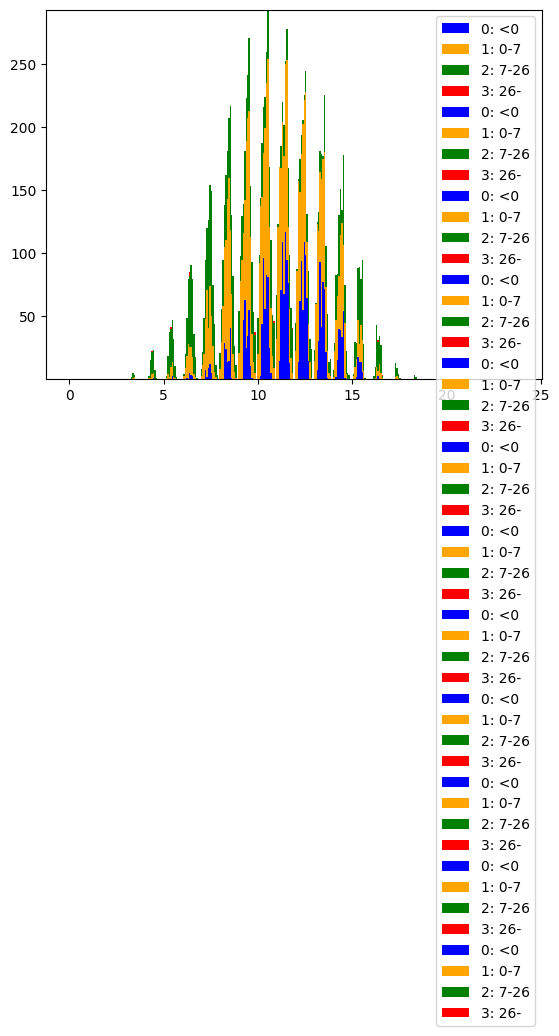

In [115]:
fig, ax6 = plt.subplots()
# Juni hh01-hh24 in 4 Kats wie oben

bar_colors = ['blue','orange','green','red']
f=0
hh_cat=pm_pv.index.levels[1]
multiplier = 0
width=1/(len(pm_pv.index.levels[0])+1)
for monat in pm_pv.index.levels[0]:
    bottom=np.zeros(len(hh_cat))
    for cur in sorted(preis_menge['+-'].unique()):
        col=bar_colors[f%4]
        f+=1
        s=[]
        for hh24 in hh_cat:
            s=s+[pm_pv.loc[monat,hh24]['PV '+cur]]    
        offset=width*multiplier
        x=ax6.bar(cats+offset, s, width, bottom=bottom, label=cur, color=col)
        bottom+=s
    multiplier += 1
    #break

ax6.legend(loc='upper right')
plt.show()
#y_pos=np.arange(len(x_axis_labels))
#ax6.bar(y_pos + 0, y_axis_values)

In [105]:
f%4

1

In [104]:
f

1

In [101]:
bottom

array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 3.89800e-01, 8.22920e+00, 2.05351e+01, 5.42116e+01,
       4.86822e+01, 6.67582e+01, 4.44939e+01, 2.33720e+01, 7.44370e+00,
       4.08000e-02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00])